# QSAR models for 3C-like protease main protease (M<sup>pro</sup>) of SARS-CoV

- Models in this workflow were generated using 2D Simplex Representation of Molecular Structure (SiRMS) descriptors ([Muratov et al., 2010](https://www.future-science.com/doi/10.4155/fmc.10.194)) calculated in the HiTQSAR software ([Kuz'min et al., 2008](https://link.springer.com/article/10.1007%2Fs10822-008-9179-6)) and Dragon 7 descriptors ([Kode Chemoinformatics srl - Pisa (Italy)](https://chm.kode-solutions.net/products_dragon.php)) along with Random Forest algorithm ([Breiman, 2001](https://link.springer.com/article/10.1023%2FA%3A1010933404324)).
- We collected 329 datapoints for 201 compounds tested in SARS-CoV M<sup>pro</sup> ([CHEMBL3927](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL3927/)). The data was carefully curated following the protocols developed by [Fourches <i>et al</i>](). After curation, 91 compounds (27 actives and 64 inactives) were kept for modeling.
- Due to the limited size of the data, we validated the models only by 5-fold external cross-validation and applied a threshold of 70% confidence to evaluate the models and to select hits for experimental validation.

## Importing modules and functions
         
    

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import _pickle as cPickle
import gzip

from BalanceBySim import *
from stats import *

from collections import Counter

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import permutation_test_score, StratifiedKFold

def warn(*args, **kwargs):
    pass
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%reload_ext autoreload
%autoreload 2
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

RDKit WARNING: [16:02:52] Enabling RDKit 2019.09.3 jupyter extensions


## Load data

Original data:  (113, 11)
Kept data:  (113, 11)


,Compound_name,Standard Type,Standard Relation,Standard Value,Standard Units,Outcome,InChIKey,Molecule ChEMBL ID,ID,SMILES,Mol
0,,IC50,=,5700.0,nM,Active,AEYIBAPLFDNVGD-UHFFFAOYNA-N,,,CC(=O)NC(CO)C(=O)NC(C)C(=O)NC(C(=O)NC(CC(C)C)C...,

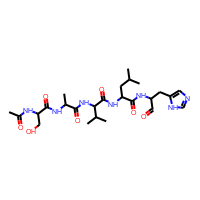

In [2]:
# Set file path
file = 'datasets/curated_data/chembl-pdb-sars-cov-3C-like-proteinase.sdf.gz'
sdfInfo = dict(smilesName='SMILES', molColName='ROMol')
moldf = PandasTools.LoadSDF(file, **sdfInfo)
print('Original data: ', moldf.shape)
# Rename ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})
# Remove missing RDKit molecules
moldf = moldf[pd.notnull(moldf['Mol'])]
if 'StandardizerResult' in moldf.columns:
    moldf = moldf.drop(columns='StandardizerResult')
# Columns
print('Kept data: ', moldf.shape)
moldf.head(1)

## Data shape

In [3]:
moldf['Outcome'] = moldf['Outcome'].replace('Active', 1)
moldf['Outcome'] = moldf['Outcome'].replace('Inactive', 0)

classes = Counter(moldf['Outcome'])
print('\033[1m' + 'Training set shape:' + '\n' + '\033[0m')
for key, value in classes.items():
    print('\t\t Class %d: %d' % (key, value))
print('\t\t Total number of compounds: %d' % (len(moldf['Outcome'])))

Training set shape:

		 Class 1: 40
		 Class 0: 73
		 Total number of compounds: 113


# SiRMS

## Import descriptors

Descriptors were calculated externally using HitQSAR. Descriptors with low variance and correlated were removed HiT QSAR using the Methods of Data Analysis module.

In [4]:
desc = pd.read_csv('descriptors/sirms-chembl-pdb-sars-cov-3C-like-proteinase.txt', skiprows=[0,1], sep='\t')
desc.drop(desc.columns[0:2], axis=1,inplace=True)
descriptors = desc.columns.difference(moldf.columns).tolist()
desc.head()

,Fr1(chg)/A,Fr1(chg)/B,Fr1(chg)/C,Fr1(chg)/D,Fr2(chg)/A_A/1_2a/,Fr2(chg)/A_A/1_2s/,Fr2(chg)/A_B/1_2a/,Fr2(chg)/A_B/1_2s/,Fr2(chg)/A_C/1_2a/,Fr2(chg)/A_C/1_2d/,...,"S_A(type)/N.AR_N.PL3_O.2_S.O2/2_4s,3_4d/4","S_A(type)/N.AR_O.2_O.2_S.O2/2_4d,3_4d/4","S_A(type)/N.AR_O.2_O.3_S.O2/1_3s,2_4d/3","S_A(type)/N.PL3_O.2_O.2_S.O2/1_4s,2_4d,3_4d/5","S_A(type)/N.PL3_O.2_O.2_S.O2/2_4d,3_4d/4","S_A(type)/N.PL3_O.2_O.3_S.O2/1_4s,2_4d/4","S_A(type)/N.PL3_O.2_S.3_S.O2/1_4s,2_4d/4","S_A(type)/O.2_O.2_O.2_S.O2/2_4d,3_4d/4","S_A(type)/O.2_O.2_O.3_S.O2/1_4d,2_4d/4","S_A(type)/O.2_O.2_S.3_S.O2/1_4d,2_4d/4"
0,14,10,36,20,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,9,16,37,9,0,0,2,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,12,13,34,17,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,5,22,26,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,18,10,30,25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
moldf_desc = pd.concat([moldf,desc], axis=1)
balance_data = 'no'

if balance_data == 'yes':
    # Balance data using 1/2 similarity and 1/2 random
    moldf_desc = BalanceBySim(moldf_desc, 'Outcome', 2)
    # Print shape
    print('Training set shape: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'train']))
    print('External set shape: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))
      
else:
    moldf_desc['Set'] = 'train'
    # Print shape
    print('Training set shape: %s' % Counter(moldf_desc['Outcome']))
    print('External set shape: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))

Training set shape: Counter({0: 73, 1: 40})
External set shape: Counter()


In [6]:
moldf_train = moldf_desc[(moldf_desc['Set'] == 'train')]

y_train = moldf_train['Outcome'].to_numpy()
X_train = moldf_train[descriptors]
X_train.shape

(113, 9401)

##### Remove constant and near constant variables

In [7]:
X_train = X_train.select_dtypes(exclude=['object'])
X_train = X_train.dropna(axis=1, how='any')
X_train = X_train.fillna(0)

# Def low variance filter (10% threshold)
def variance_filter(data, threshold=0.1):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# Apply filter
X_train = variance_filter(X_train)

##### Remove correlated variables

In [8]:
%%time
correlated_features = set()  
correlation_matrix = X_train.corr()

for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

X_train.drop(labels=correlated_features, axis=1, inplace=True)

X_train.shape

Wall time: 3min 42s


(113, 1262)

In [9]:
X_train.to_csv('descriptors/sirms-chembl-sars-cov-3C-like-proteinase-processed.txt', sep='\t', index=False)

## Model building

### Modeling data

##### Find best parameters

In [10]:
%%time
# Number of trees in random forest
n_estimators = [100, 250, 500, 750, 1000]
max_features = ['auto', 'sqrt']
criterion = ['gini', 'entropy']
if balance_data == 'yes':
    class_weight = [None]
else:
    class_weight = [None,'balanced',
                    {0:.9, 1:.1}, {0:.8, 1:.2}, {0:.7, 1:.3}, {0:.6, 1:.4},
                    {0:.4, 1:.6}, {0:.3, 1:.7}, {0:.2, 1:.8}, {0:.1, 1:.9}]
random_state = [33]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'criterion': criterion,
              'random_state': random_state,
              'class_weight': class_weight}

# setup model building
rf = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1, cv=5, verbose=1)
rf.fit(X_train, y_train)
print()
print('Best params: %s' % rf.best_params_)
print('Score: %.2f' % rf.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.0min finished



Best params: {'class_weight': {0: 0.7, 1: 0.3}, 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100, 'random_state': 33}
Score: 0.79
Wall time: 5min


##### Model w/ best parameters

In [11]:
rf_best = RandomForestClassifier(**rf.best_params_, n_jobs=-1)
rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.7, 1: 0.3}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=33, verbose=0, warm_start=False)

##### 5-fold cross-validation

In [12]:
# Params
pred = []
ad = []
index = []
cross_val = StratifiedKFold(n_splits=5)

# Do 5-fold loop
for train_index, test_index in cross_val.split(X_train, y_train):
    
    fold_model = rf_best.fit(X_train.iloc[train_index], y_train[train_index])
    fold_pred = rf_best.predict(X_train.iloc[test_index])
    fold_ad = rf_best.predict_proba(X_train.iloc[test_index])
    pred.append(fold_pred)
    ad.append(fold_ad)
    index.append(test_index)

In [13]:
threshold_ad = 0.70

# Prepare results to export    
fold_index = np.concatenate(index)    
fold_pred = np.concatenate(pred)
fold_ad = np.concatenate(ad)
fold_ad = (np.amax(fold_ad, axis=1) >= threshold_ad).astype(str)
five_fold_sirms = pd.DataFrame({'Prediction': fold_pred,'AD': fold_ad}, index=list(fold_index))
five_fold_sirms.AD[five_fold_sirms.AD == 'False'] = np.nan
five_fold_sirms.AD[five_fold_sirms.AD == 'True'] = five_fold_sirms.Prediction
five_fold_sirms.sort_index(inplace=True)
five_fold_sirms['y_train'] = pd.DataFrame(y_train)
five_fold_sirms_ad = five_fold_sirms.dropna().astype(int)
coverage_5f = len(five_fold_sirms_ad) / len(five_fold_sirms)

# sirms stats
sirms = pd.DataFrame(stats(five_fold_sirms['y_train'], five_fold_sirms['Prediction']))
sirms['Coverage'] = 1.0

# sirms AD stats
sirms_ad = five_fold_sirms.dropna(subset=['AD']).astype(int)
coverage_sirms_ad = len(sirms_ad['AD']) / len(five_fold_sirms['y_train'])
sirms_ad = pd.DataFrame(stats(sirms_ad['y_train'], sirms_ad['AD']))
sirms_ad['Coverage'] = round(coverage_sirms_ad, 2)

# print stats
print('\033[1m' + '5-fold External Cross Validation Statistical Characteristcs of QSAR models developed SiRMS' + '\n' + '\033[0m')
sirms_5f_stats = sirms.append(sirms_ad)
sirms_5f_stats.set_index([['SiRMS', 'SiRMS AD']], drop=True, inplace=True)
sirms_5f_stats

5-fold External Cross Validation Statistical Characteristcs of QSAR models developed SiRMS



,Kappa,CCR,Sensitivity,PPV,Specificity,NPV,Coverage
SiRMS,0.52,0.76,0.65,0.72,0.86,0.82,1.00
SiRMS AD,0.68,0.83,0.72,0.86,0.93,0.85,0.61


##### Predict external withheld set after balancing

In [14]:
moldf_ext = moldf_desc[(moldf_desc['Set'] == 'ext')]
descriptor_list = list(X_train.columns.values)

if len(moldf_ext) > 0:
    y_ext = moldf_ext['Outcome'].to_numpy()
    X_ext = moldf_ext[descriptors]
    
    # Filter out descriptors not present in the model
    X_ext = X_ext[descriptor_list]
    
    # Make predictions
    ext_set_sirms = rf_best.predict(X_ext)
    ext_set_sirms_ad = rf_best.predict_proba(X_ext)
    ext_set_sirms_ad = (np.amax(ext_set_sirms_ad, axis=1) >= threshold_ad).astype(str)
    
    # Prepare data
    ext_set_sirms = pd.DataFrame({'Prediction': ext_set_sirms,'AD': ext_set_sirms_ad})
    ext_set_sirms.AD[ext_set_sirms.AD == 'False'] = np.nan
    ext_set_sirms.AD[ext_set_sirms.AD == 'True'] = ext_set_sirms.Prediction
    ext_set_sirms.sort_index(inplace=True)
    ext_set_sirms['y_ext'] = pd.DataFrame(y_ext)
    ext_set_sirms_ad = ext_set_sirms.dropna().astype(int)
    coverage_ext = len(ext_set_sirms_ad) / len(ext_set_sirms)
    
    # ext_set_sirms stats
    sirms_ext = pd.DataFrame(stats(ext_set_sirms['y_ext'], ext_set_sirms['Prediction']))
    sirms_ext['Coverage'] = 1.0
    
    # ext_set_sirms AD stats
    sirms_ext_ad = ext_set_sirms.dropna(subset=['AD']).astype(int)
    coverage_sirms_ext_ad = len(sirms_ext_ad['AD']) / len(ext_set_sirms['y_ext'])
    sirms_ext_ad = pd.DataFrame(stats(sirms_ext_ad['y_ext'], sirms_ext_ad['AD']))
    sirms_ext_ad['Coverage'] = round(coverage_sirms_ext_ad, 2)
    
    # print stats
    print('\033[1m' + 'Statistical Characteristcs of the Prediction of the External Withheld Set by SiRMS Models' + '\n' + '\033[0m')
    ext_set_sirms_stats = sirms_ext.append(sirms_ext_ad)
    ext_set_sirms_stats.set_index([['SiRMS Ext.', 'SiRMS Ext. AD']], drop=True, inplace=True)
    ext_set_sirms_stats
else:
    pass

##### Y-randomization

In [15]:
permutations = 20
score, permutation_scores, pvalue = permutation_test_score(rf_best, X_train, y_train,
                                                           cv=5, scoring='balanced_accuracy',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=24)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


True score =  0.76 
Y-randomization =  0.49 
p-value =  0.0476


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.0s finished


##### Save model

In [16]:
with gzip.GzipFile('model/sars-cov-3clpro-sirms_RF_ad_balanced.pgz', 'w') as f:
    cPickle.dump(rf_best, f)

### Plot stats

In [17]:
# Export stats
if len(moldf_ext) > 0:
    sirms_stats = pd.concat([sirms_5f_stats, ext_set_sirms_stats], axis=0)
    sirms_stats
else:
    sirms_stats = sirms_5f_stats.copy()

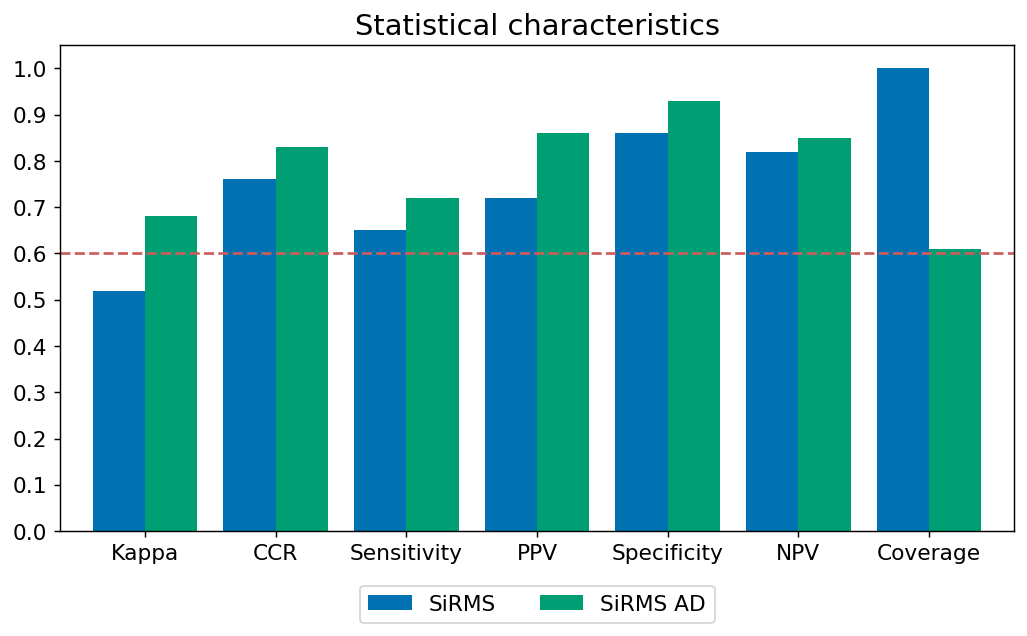

In [18]:
# Transpose stats
sirms_stats_t = sirms_stats.T
sirms_stats_t = sirms_stats_t.reset_index()
sirms_stats_t = sirms_stats_t.rename(columns={'index': 'Stats'})

# Make plot
plt.style.use('seaborn-colorblind')
fig, ax1 = plt.subplots(figsize=(8,5), dpi=130)

sirms_stats_t.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_xticklabels(labels=sirms_stats_t['Stats'].tolist(), fontsize=14, rotation=0)
ax1.axhline(y=.6, color='indianred', ls='dashed')
ax1.legend_.remove()
plt.title('Statistical characteristics', fontsize=16)
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.tick_params(labelsize=12)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=12,
            loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=4)
fig.tight_layout()

plt.savefig('statistics-sirms.png', bbox_inches='tight', transparent=False, format='png', dpi=300)
plt.show();

# DRAGON

## Import descriptors

Descriptors were calculated externally using HitQSAR

In [19]:
desc = pd.read_csv('descriptors/dragon-chembl-pdb-sars-cov-3C-like-proteinase.txt', sep='\t')
desc.drop(desc.columns[0:1], axis=1,inplace=True)
descriptors = desc.columns.difference(moldf.columns).tolist()
desc.head()

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,Psychotic-80,Psychotic-50,Hypertens-80,Hypertens-50,Hypnotic-80,Hypnotic-50,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50
0,551.73,6.897,46.109,81.025,48.165,92.012,0.576,1.013,0.602,1.150,...,0,0,0,0,0,0,0,0,0,0
1,515.68,7.263,44.143,71.181,46.302,80.514,0.622,1.003,0.652,1.134,...,0,0,0,0,0,0,0,0,0,0
2,521.70,6.864,43.867,76.814,45.949,87.388,0.577,1.011,0.605,1.150,...,0,0,0,0,0,0,0,0,0,0
3,428.57,7.143,38.036,59.672,40.273,67.022,0.634,0.995,0.671,1.117,...,1,0,1,0,0,0,1,0,1,0
4,638.71,7.695,50.135,85.676,50.671,95.146,0.604,1.032,0.610,1.146,...,0,0,0,0,0,0,0,0,0,0


In [20]:
moldf_desc = pd.concat([moldf,desc], axis=1)
balance_data = 'no'

if balance_data == 'yes':
    # Balance data using 1/2 similarity and 1/2 random
    moldf_desc = BalanceBySim(moldf_desc, 'Outcome', 2)
    # Print shape
    print('Training set shape: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'train']))
    print('External set shape: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))
      
else:
    moldf_desc['Set'] = 'train'
    # Print shape
    print('Training set shape: %s' % Counter(moldf_desc['Outcome']))
    print('External set shape: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))

Training set shape: Counter({0: 73, 1: 40})
External set shape: Counter()


In [21]:
moldf_train = moldf_desc[(moldf_desc['Set'] == 'train')]

y_train = moldf_train['Outcome'].to_numpy()
X_train = moldf_train[descriptors]
X_train.shape

(113, 4567)

##### Remove constant and near constant variables

In [22]:
X_train = X_train.select_dtypes(exclude=['object'])
X_train = X_train.dropna(axis=1, how='any')
X_train = X_train.fillna(0)

# Def low variance filter (10% threshold)
def variance_filter(data, threshold=0.1):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# Apply filter
X_train = variance_filter(X_train)

##### Remove correlated variables

In [23]:
correlated_features = set()  
correlation_matrix = X_train.corr()

for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

X_train.drop(labels=correlated_features, axis=1, inplace=True)

X_train.shape

(113, 378)

In [24]:
X_train.to_csv('descriptors/dragon-chembl-sars-cov-3C-like-proteinase-processed.txt', sep='\t', index=False)

## Model building

### Modeling data

##### Find best parameters

In [25]:
%%time
# Number of trees in random forest
n_estimators = [100, 250, 500, 750, 1000]
max_features = ['auto', 'sqrt']
criterion = ['gini', 'entropy']
if balance_data == 'yes':
    class_weight = [None]
else:
    class_weight = [None,'balanced',
                    {0:.9, 1:.1}, {0:.8, 1:.2}, {0:.7, 1:.3}, {0:.6, 1:.4},
                    {0:.4, 1:.6}, {0:.3, 1:.7}, {0:.2, 1:.8}, {0:.1, 1:.9}]
random_state = [33]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'criterion': criterion,
              'random_state': random_state,
              'class_weight': class_weight}

# setup model building
rf = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1, cv=5, verbose=1)
rf.fit(X_train, y_train)
print()
print('Best params: %s' % rf.best_params_)
print('Score: %.2f' % rf.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.9min finished



Best params: {'class_weight': {0: 0.3, 1: 0.7}, 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 500, 'random_state': 33}
Score: 0.76
Wall time: 4min 53s


##### Model w/ best parameters

In [26]:
rf_best = RandomForestClassifier(**rf.best_params_, n_jobs=-1)
rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.3, 1: 0.7}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=33, verbose=0, warm_start=False)

##### 5-fold cross-validation

In [27]:
# Params
pred = []
ad = []
index = []
cross_val = StratifiedKFold(n_splits=5)

# Do 5-fold loop
for train_index, test_index in cross_val.split(X_train, y_train):
    
    fold_model = rf_best.fit(X_train.iloc[train_index], y_train[train_index])
    fold_pred = rf_best.predict(X_train.iloc[test_index])
    fold_ad = rf_best.predict_proba(X_train.iloc[test_index])
    pred.append(fold_pred)
    ad.append(fold_ad)
    index.append(test_index)

threshold_ad = 0.70

# Prepare results to export    
fold_index = np.concatenate(index)    
fold_pred = np.concatenate(pred)
fold_ad = np.concatenate(ad)
fold_ad = (np.amax(fold_ad, axis=1) >= threshold_ad).astype(str)
five_fold_dragon = pd.DataFrame({'Prediction': fold_pred,'AD': fold_ad}, index=list(fold_index))
five_fold_dragon.AD[five_fold_dragon.AD == 'False'] = np.nan
five_fold_dragon.AD[five_fold_dragon.AD == 'True'] = five_fold_dragon.Prediction
five_fold_dragon.sort_index(inplace=True)
five_fold_dragon['y_train'] = pd.DataFrame(y_train)
five_fold_dragon_ad = five_fold_dragon.dropna().astype(int)
coverage_5f = len(five_fold_dragon_ad) / len(five_fold_dragon)

# dragon stats
dragon = pd.DataFrame(stats(five_fold_dragon['y_train'], five_fold_dragon['Prediction']))
dragon['Coverage'] = 1.0

# dragon AD stats
dragon_ad = five_fold_dragon.dropna(subset=['AD']).astype(int)
coverage_dragon_ad = len(dragon_ad['AD']) / len(five_fold_dragon['y_train'])
dragon_ad = pd.DataFrame(stats(dragon_ad['y_train'], dragon_ad['AD']))
dragon_ad['Coverage'] = round(coverage_dragon_ad, 2)

# print stats
print('\033[1m' + '5-fold External Cross Validation Statistical Characteristcs of QSAR models developed Dragon' + '\n' + '\033[0m')
dragon_5f_stats = dragon.append(dragon_ad)
dragon_5f_stats.set_index([['Dragon', 'Dragon AD']], drop=True, inplace=True)
dragon_5f_stats

5-fold External Cross Validation Statistical Characteristcs of QSAR models developed Dragon



,Kappa,CCR,Sensitivity,PPV,Specificity,NPV,Coverage
Dragon,0.45,0.71,0.55,0.71,0.88,0.78,1.00
Dragon AD,0.65,0.78,0.56,1.00,1.00,0.87,0.54


##### Predict external withheld set after balancing

In [28]:
moldf_ext = moldf_desc[(moldf_desc['Set'] == 'ext')]
descriptor_list = list(X_train.columns.values)

if len(moldf_ext) > 0:
    y_ext = moldf_ext['Outcome'].to_numpy()
    X_ext = moldf_ext[descriptors]
    
    # Filter out descriptors not present in the model
    X_ext = X_ext[descriptor_list]
    
    # Make predictions
    ext_set_dragon = rf_best.predict(X_ext)
    ext_set_dragon_ad = rf_best.predict_proba(X_ext)
    ext_set_dragon_ad = (np.amax(ext_set_dragon_ad, axis=1) >= threshold_ad).astype(str)
    
    # Prepare data
    ext_set_dragon = pd.DataFrame({'Prediction': ext_set_dragon,'AD': ext_set_dragon_ad})
    ext_set_dragon.AD[ext_set_dragon.AD == 'False'] = np.nan
    ext_set_dragon.AD[ext_set_dragon.AD == 'True'] = ext_set_dragon.Prediction
    ext_set_dragon.sort_index(inplace=True)
    ext_set_dragon['y_ext'] = pd.DataFrame(y_ext)
    ext_set_dragon_ad = ext_set_dragon.dropna().astype(int)
    coverage_ext = len(ext_set_dragon_ad) / len(ext_set_dragon)
    
    # ext_set_dragon stats
    dragon_ext = pd.DataFrame(stats(ext_set_dragon['y_ext'], ext_set_dragon['Prediction']))
    dragon_ext['Coverage'] = 1.0
    
    # ext_set_dragon AD stats
    dragon_ext_ad = ext_set_dragon.dropna(subset=['AD']).astype(int)
    coverage_dragon_ext_ad = len(dragon_ext_ad['AD']) / len(ext_set_dragon['y_ext'])
    dragon_ext_ad = pd.DataFrame(stats(dragon_ext_ad['y_ext'], dragon_ext_ad['AD']))
    dragon_ext_ad['Coverage'] = round(coverage_dragon_ext_ad, 2)
    
    # print stats
    print('\033[1m' + 'Statistical Characteristcs of the Prediction of the External Withheld Set by Dragon Models' + '\n' + '\033[0m')
    ext_set_dragon_stats = dragon_ext.append(dragon_ext_ad)
    ext_set_dragon_stats.set_index([['Dragon Ext.', 'Dragon Ext. AD']], drop=True, inplace=True)
    ext_set_dragon_stats
else:
    pass

##### Y-randomization

In [29]:
permutations = 20
score, permutation_scores, pvalue = permutation_test_score(rf_best, X_train, y_train,
                                                           cv=5, scoring='balanced_accuracy',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=24)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


True score =  0.71 
Y-randomization =  0.51 
p-value =  0.0476


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   30.6s finished


##### Save model

In [30]:
with gzip.GzipFile('model/sars-cov-3clpro-dragon_RF_ad_balanced.pgz', 'w') as f:
    cPickle.dump(rf_best, f)

### Plot stats

In [31]:
# Export stats
if len(moldf_ext) > 0:
    dragon_stats = pd.concat([dragon_5f_stats, ext_set_dragon_stats], axis=0)
    dragon_stats
else:
    dragon_stats = dragon_5f_stats.copy()
    dragon_stats

,Kappa,CCR,Sensitivity,PPV,Specificity,NPV,Coverage
Dragon,0.45,0.71,0.55,0.71,0.88,0.78,1.00
Dragon AD,0.65,0.78,0.56,1.00,1.00,0.87,0.54


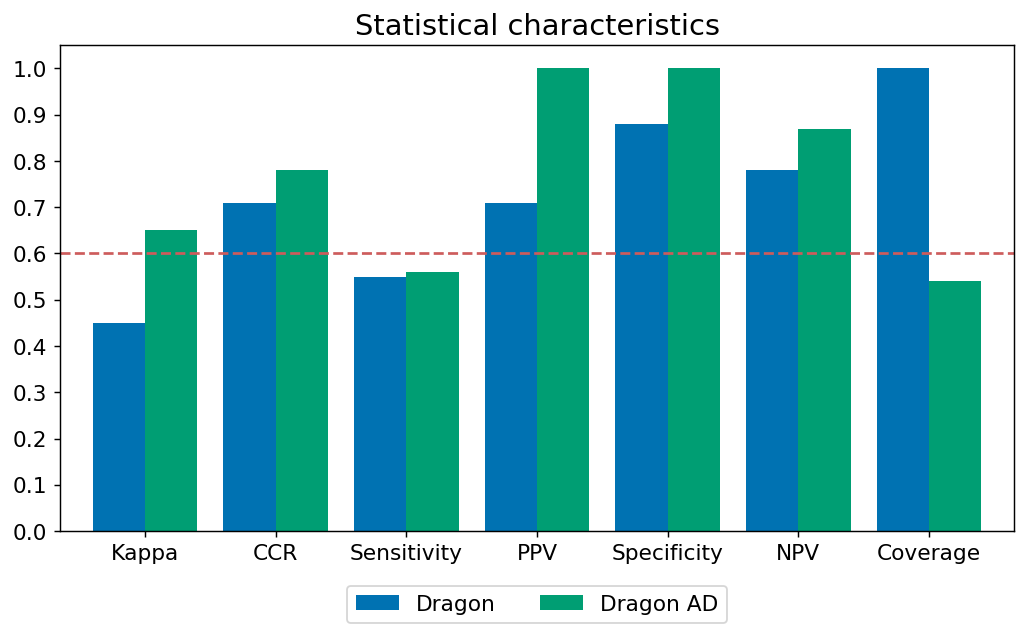

In [32]:
# Transpose stats
dragon_stats_t = dragon_stats.T
dragon_stats_t = dragon_stats_t.reset_index()
dragon_stats_t = dragon_stats_t.rename(columns={'index': 'Stats'})

# Make plot
plt.style.use('seaborn-colorblind')
fig, ax1 = plt.subplots(figsize=(8,5), dpi=130)

dragon_stats_t.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_xticklabels(labels=dragon_stats_t['Stats'].tolist(), fontsize=14, rotation=0)
ax1.axhline(y=.6, color='indianred', ls='dashed')
ax1.legend_.remove()
plt.title('Statistical characteristics', fontsize=16)
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.tick_params(labelsize=12)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=12,
            loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=4)
fig.tight_layout()

plt.savefig('statistics-dragon.png', bbox_inches='tight', transparent=False, format='png', dpi=300)
plt.show();

# Consensus

In [33]:
results_sirms = five_fold_sirms.drop(columns='y_train')
results_sirms = five_fold_sirms.rename(columns={'Prediction':'sirms', 'AD':'sirms_ad'})
results_dragon = five_fold_dragon.drop(columns='y_train')
results_dragon = five_fold_dragon.rename(columns={'Prediction':'dragon', 'AD':'dragon_ad'})

In [34]:
var = list(moldf.columns.values)
moldf_train = moldf_train[var]
predictions = pd.concat([moldf_train.reset_index(drop=True), results_sirms, results_dragon], axis=1)

#### Consensus predictions

In [35]:
# Consensus
predictions['consensus'] = (predictions.sirms + predictions.dragon)/2
predictions['consensus'] = np.where(predictions['consensus'] > 0.5, 1, 0)

# Consensus AD
for i in range(0, predictions.shape[0]):
    if all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = (predictions.sirms_ad[i] + predictions.dragon_ad[i])/2
        predictions.loc[i,'consensus_ad'] = np.where(predictions.loc[i,'consensus_ad'] > 0.5, 1, 0)
    elif all([np.isnan(predictions.sirms_ad[i]) == True, np.isnan(predictions.dragon_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = predictions.dragon_ad[i]
    elif all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == True]):
        predictions.loc[i,'consensus_ad'] = predictions.sirms_ad[i]
    else:
        predictions.loc[i,'consensus_ad']  = np.nan

# Consensus Rigor
for i in range(0, predictions.shape[0]):
    if all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == False]):
        predictions.loc[i,'consensus_rigor'] = (predictions.sirms_ad[i] + predictions.dragon_ad[i])/2
        predictions.loc[i,'consensus_rigor'] = np.where(predictions.loc[i,'consensus_rigor'] > 0.5, 1, 0)
    else:
        predictions.loc[i,'consensus_rigor']  = np.nan
        
predictions.drop(columns=['y_train', 'ID'], inplace=True)

In [36]:
##### SiRMS

# SiRMS stats
sirms = pd.DataFrame(stats(predictions.Outcome, predictions.sirms))
sirms['Coverage'] = 1.0

# SiRMS AD stats
sirms_ad = predictions.dropna(subset=['sirms_ad'])
coverage_sirms_ad = len(sirms_ad.sirms_ad) / len(predictions.Outcome)
sirms_ad = pd.DataFrame(stats(sirms_ad.Outcome, sirms_ad.sirms_ad.astype(int)))
sirms_ad['Coverage'] = round(coverage_sirms_ad, 2)

##### DRAGON

# dragon stats
dragon = pd.DataFrame(stats(predictions.Outcome, predictions.dragon))
dragon['Coverage'] = 1.0

# dragon AD stats
dragon_ad = predictions.dropna(subset=['dragon_ad'])
coverage_dragon_ad = len(dragon_ad.dragon_ad) / len(predictions.Outcome)
dragon_ad = pd.DataFrame(stats(dragon_ad.Outcome, dragon_ad.dragon_ad.astype(int)))
dragon_ad['Coverage'] = round(coverage_dragon_ad, 2)

##### Consensus

# consensus stats
consensus = pd.DataFrame(stats(predictions.Outcome, predictions.consensus))
consensus['Coverage'] = 1.0

# consensus AD stats
consensus_ad = predictions.dropna(subset=['consensus_ad'])
coverage_consensus_ad = len(consensus_ad.consensus_ad) / len(predictions.Outcome)

consensus_ad = pd.DataFrame(stats(consensus_ad.Outcome, consensus_ad.consensus_ad.astype(int)))
consensus_ad['Coverage'] = round(coverage_consensus_ad, 2)

# consensus rigor stats
consensus_rigor = predictions.dropna(subset=['consensus_rigor'])
coverage_consensus_rigor = len(consensus_rigor.consensus_rigor) / len(predictions.Outcome)
consensus_rigor = pd.DataFrame(stats(consensus_rigor.Outcome, consensus_rigor.consensus_rigor.astype(int)))
consensus_rigor['Coverage'] = round(coverage_consensus_rigor, 2)

##### Export predictions

In [37]:
pred_exp = predictions.drop(columns=['Mol'])

with pd.ExcelWriter('predictions-sirms-dragon.xlsx') as writer:
    pred_exp.to_excel(writer, sheet_name='sirms-dragon', index=False)

##### Stats

In [38]:
stats = pd.concat([sirms_ad, dragon_ad, consensus, consensus_ad, consensus_rigor], axis=0)
stats.set_index([['SiRMS', 'Dragon', 'Consensus', 'Consensus (AD)', 'Consensus Rigor']], drop=True, inplace=True)

stats

,Kappa,CCR,Sensitivity,PPV,Specificity,NPV,Coverage
SiRMS,0.68,0.83,0.72,0.86,0.93,0.85,0.61
Dragon,0.65,0.78,0.56,1.00,1.00,0.87,0.54
Consensus,0.48,0.72,0.52,0.78,0.92,0.78,1.00
Consensus (AD),0.62,0.79,0.64,0.86,0.94,0.83,0.71
Consensus Rigor,0.77,0.85,0.69,1.00,1.00,0.90,0.44


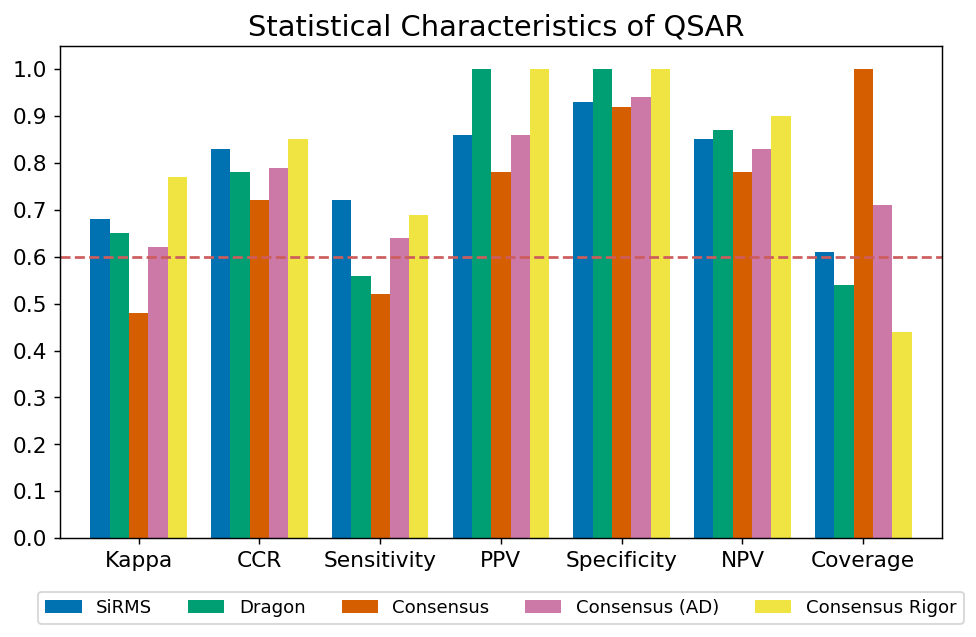

In [39]:
# Transpose stats
stats_t = stats.T
stats_t = stats_t.reset_index()
stats_t = stats_t.rename(columns={'index': 'Stats'})

# Make plot
plt.style.use('seaborn-colorblind')
fig, ax1 = plt.subplots(figsize=(8,5), dpi=130)

stats_t.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_xticklabels(labels=stats_t['Stats'].tolist(), fontsize=14, rotation=0)
ax1.axhline(y=.6, color='indianred', ls='dashed')
ax1.legend_.remove()
plt.title('Statistical Characteristics of QSAR ', fontsize=16)
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.tick_params(labelsize=12)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10,
            loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=5)
fig.tight_layout()

plt.savefig('statistics-sirms-dragon-5f.png', bbox_inches='tight', transparent=False, format='png', dpi=300)
plt.show();